# American Sign Language Prediction Using Computer Vision ANN

___
## 1. Introduction

**Name:** Yonathan Anggraiwan

I am a Data Engineer developing a computer vision program powered by an **Artificial Neural Network (ANN)** for a public service organization. The core task of this project is to build a model that can recognize images or objects representing **sign language gestures**, specifically from the **American Sign Language (ASL)** system.

The users of this project include anyone interested in learning or communicating with individuals who are deaf or hard of hearing.

The objective of this modeling process is to explore various **feature engineering techniques and hyperparameter configurations** in computer vision, in order to achieve high prediction accuracy with minimal error.

Here is the deployment link to the working application:  
🔗 [https://asl-hand-language-classification-rvpishere.streamlit.app/](https://asl-hand-language-classification-rvpishere.streamlit.app/)

___
## 2. Import Libraries

The first step before loading the data is to import the required libraries. Below are the libraries that will be used:

In [ ]:
# === TensorFlow & Keras ===
import tensorflow as tf                                                                         # Main ML framework
from tensorflow.keras import Sequential                                                         # Sequential model architecture
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
                                     Rescaling, BatchNormalization,
                                     GlobalAveragePooling2D,
                                     RandomFlip, RandomZoom)                                    # CNN layers & data augmentation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau                         # Training stability callbacks
from tensorflow.keras import regularizers                                                       # Regularization methods (L1/L2)
from tensorflow.keras.optimizers import Adam                                                    # Model optimizer

# === System & Utilities ===
import os                           # File and directory operations
import shutil                       # File copy and deletion
import time                         # Measure training duration
import random                       # Random operations like sampling
import pickle                       # Save and load Python objects
import warnings                     # Suppress runtime warnings
from PIL import Image
warnings.filterwarnings('ignore')

# === Visualization & Monitoring ===
import matplotlib.pyplot as plt     # Plotting and graphs
import seaborn as sns               # Distribution plots and heatmaps
import matplotlib.image as mpimg    # Display images using Matplotlib
from tqdm import tqdm               # Progress bar for iterations

# === Data Analysis ===
import numpy as np                  # Array & vector operations
import pandas as pd                 # Tabular data analysis

# === Model Evaluation ===
from sklearn.metrics import classification_report           # Model prediction evaluation
from tensorflow.keras.layers import RandomContrast          # Image contrast augmentation

After importing the necessary libraries, the next step is to write code that ensures the GPU device does not allocate all available memory during the modeling process.

In [ ]:
# (Optional) Prevent GPU from allocating all memory at startup
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

The next step is data loading and splitting, using a dataset sourced from [Kaggle](https://www.kaggle.com/datasets/signnteam/asl-sign-language-pictures-minus-j-z). This dataset consists of images of American Sign Language (ASL) gestures, representing 24 alphabet letters ranging from A to Z, excluding the letters J and Z.

Each label contains a different number of images, which will be further analyzed during the Exploratory Data Analysis (EDA) stage.

After the dataset is loaded, it will be split proportionally into 70% training data and 30% validation data, ensuring an appropriate distribution for model training and performance evaluation.

___
## 3. Data Loading & Data Splitting

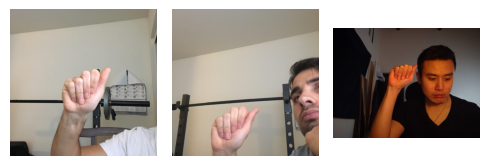

In [ ]:
# === Path to the dataset folder ===
data_dir = 'data'  # Make sure the 'data' folder is located in your working directory

# === Pick one label class (e.g., 'A') for demonstration ===
sample_class = os.path.join(data_dir, os.listdir(data_dir)[0])  # Select the first label folder
sample_images = os.listdir(sample_class)[:3]  # Take the first 3 images from the selected label

# === Display the selected images ===
plt.figure(figsize=(5, 5))
for i, img_name in enumerate(sample_images):
    img_path = os.path.join(sample_class, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()

After successfully loading the image dataset, the next step is to split the data into two subsets: training and validation. This allows the model to learn from a portion of the data (training set) while being evaluated on unseen data (validation set) to ensure it generalizes well.

___
### 3.1 Data Splitting

In [ ]:
# === Source and target paths ===
original_data_dir = './data'  # Folder containing subfolders for each class
base_output_dir = './split_data'
train_dir = os.path.join(base_output_dir, 'training')
val_dir = os.path.join(base_output_dir, 'validation')
test_dir = os.path.join(base_output_dir, 'test')

# === Split ratios (60% train, 15% val, 15% test) ===
val_split = 0.15
test_split = 0.15
random.seed(42)

# === Create output folders if they don't exist ===
for split_dir in [train_dir, val_dir, test_dir]:
    os.makedirs(split_dir, exist_ok=True)

# === Process each class folder ===
for class_name in os.listdir(original_data_dir):
    class_path = os.path.join(original_data_dir, class_name)
    if not os.path.isdir(class_path):
        continue  # Skip non-folder entries

    # Filter image files only
    images = [img for img in os.listdir(class_path)
              if img.lower().endswith(('.jpg', '.jpeg', '.png'))]

    random.shuffle(images)
    total = len(images)

    test_count = int(total * test_split)
    val_count = int(total * val_split)
    train_count = total - test_count - val_count

    train_images = images[:train_count]
    val_images = images[train_count:train_count + val_count]
    test_images = images[train_count + val_count:]

    # Create class subfolders in each split directory
    for split_root in [train_dir, val_dir, test_dir]:
        os.makedirs(os.path.join(split_root, class_name), exist_ok=True)

    # Copy training images
    for img in tqdm(train_images, desc=f'Training - {class_name}', leave=False):
        src = os.path.join(class_path, img)
        dst = os.path.join(train_dir, class_name, img)
        shutil.copy2(src, dst)

    # Copy validation images
    for img in tqdm(val_images, desc=f'Validation - {class_name}', leave=False):
        src = os.path.join(class_path, img)
        dst = os.path.join(val_dir, class_name, img)
        shutil.copy2(src, dst)

    # Copy test images
    for img in tqdm(test_images, desc=f'Test - {class_name}', leave=False):
        src = os.path.join(class_path, img)
        dst = os.path.join(test_dir, class_name, img)
        shutil.copy2(src, dst)

print("✅ Dataset berhasil dipisahkan ke training, validation, dan test folders!")

✅ Dataset berhasil dipisahkan ke training, validation, dan test folders!


After successfully splitting the dataset, the next step is to define the storage paths for each data subset. This helps streamline the coding and modeling process by clearly specifying the directory structure for training, validation, and test data.

By organizing the data into labeled folders and setting consistent paths, the model can access images efficiently during preprocessing and training stages.
___

In [4]:
# Define path
main_path = './split_data/'
train_path = os.path.join(main_path, 'training')
val_path = os.path.join(main_path, 'validation')
test_path = os.path.join(main_path, 'test')

train_path

'./split_data/training'

Once the storage paths have been established, the next step is to verify whether the data has been correctly placed within each directory. This ensures that the training, validation, and test folders are not empty and that each class contains the expected image files
___

In [5]:
# Check how many data in `train_path` and `test_path`

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Validation Path')
check_path(val_path)
print('')

print('Test Path')
check_path(test_path)
print('')

Train Path
Total Data - A : 379
Total Data - B : 379
Total Data - C : 271
Total Data - D : 267
Total Data - E : 350
Total Data - F : 294
Total Data - G : 243
Total Data - H : 256
Total Data - I : 252
Total Data - K : 225
Total Data - L : 244
Total Data - M : 195
Total Data - N : 207
Total Data - O : 262
Total Data - P : 155
Total Data - Q : 193
Total Data - R : 205
Total Data - S : 220
Total Data - T : 211
Total Data - U : 202
Total Data - V : 237
Total Data - W : 243
Total Data - X : 218
Total Data - Y : 224

Validation Path
Total Data - A : 80
Total Data - B : 81
Total Data - C : 58
Total Data - D : 56
Total Data - E : 74
Total Data - F : 63
Total Data - G : 51
Total Data - H : 54
Total Data - I : 54
Total Data - K : 47
Total Data - L : 51
Total Data - M : 41
Total Data - N : 43
Total Data - O : 56
Total Data - P : 33
Total Data - Q : 41
Total Data - R : 43
Total Data - S : 47
Total Data - T : 45
Total Data - U : 42
Total Data - V : 50
Total Data - W : 52
Total Data - X : 46
Total Da

Once the storage paths have been established, the next step is to verify whether the data has been correctly placed within each directory. This ensures that the training, validation, and test folders are not empty and that each class contains the expected image files.
___


Label: A — Menampilkan 5 gambar


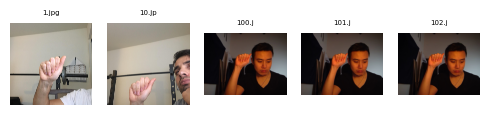


Label: B — Menampilkan 5 gambar


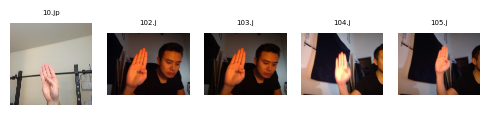


Label: C — Menampilkan 5 gambar


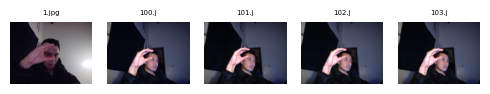


Label: D — Menampilkan 5 gambar


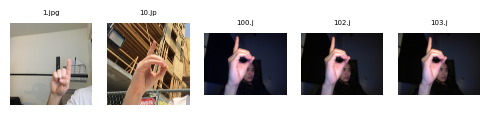


Label: E — Menampilkan 5 gambar


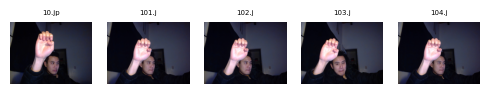


Label: F — Menampilkan 5 gambar


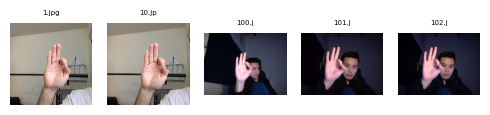


Label: G — Menampilkan 5 gambar


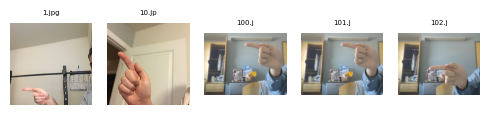


Label: H — Menampilkan 5 gambar


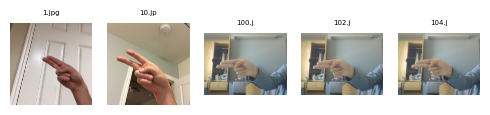


Label: I — Menampilkan 5 gambar


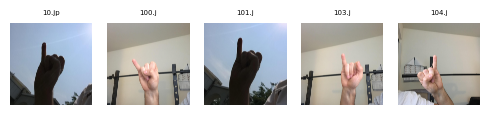


Label: K — Menampilkan 5 gambar


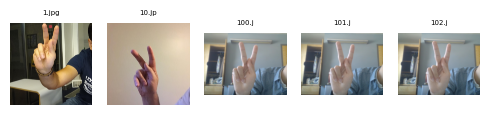


Label: L — Menampilkan 5 gambar


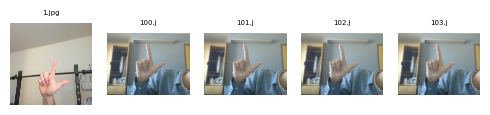


Label: M — Menampilkan 5 gambar


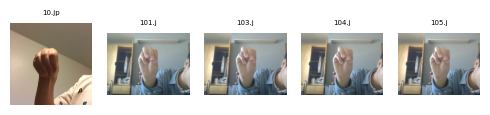


Label: N — Menampilkan 5 gambar


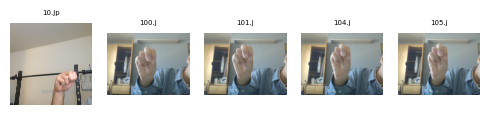


Label: O — Menampilkan 5 gambar


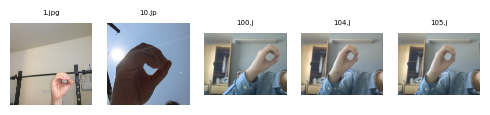


Label: P — Menampilkan 5 gambar


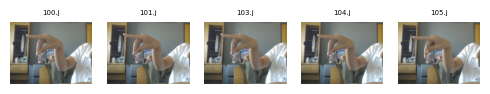


Label: Q — Menampilkan 5 gambar


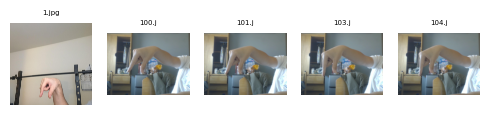


Label: R — Menampilkan 5 gambar


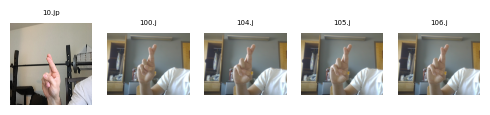


Label: S — Menampilkan 5 gambar


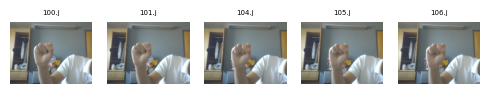


Label: T — Menampilkan 5 gambar


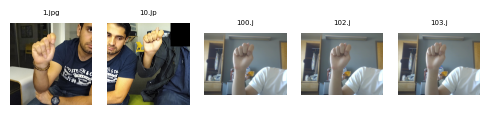


Label: U — Menampilkan 5 gambar


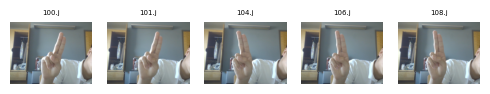


Label: V — Menampilkan 5 gambar


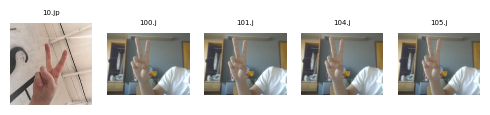


Label: W — Menampilkan 5 gambar


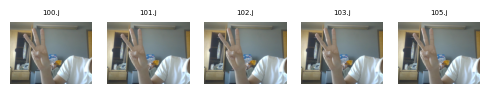


Label: X — Menampilkan 5 gambar


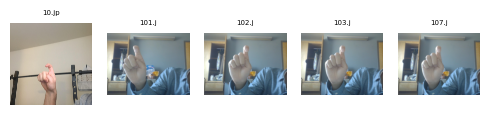


Label: Y — Menampilkan 5 gambar


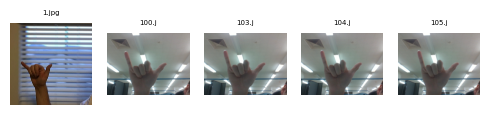

In [ ]:
def is_image_file(filename):
    # Check if the file has a valid image extension
    return filename.lower().endswith(('.jpg', '.jpeg', '.png'))

def show_sample_images_per_class(base_path='./split_data/training', samples=5):
    # Get and sort all class labels (folder names) in the training directory
    labels = sorted(os.listdir(base_path))

    for label in labels:
        folder_path = os.path.join(base_path, label)
        if not os.path.isdir(folder_path):
            continue  # Skip if not a folder

        # Get all image files in the folder
        images = [f for f in os.listdir(folder_path) if is_image_file(f)]
        if not images:
            print(f"No images found for label '{label}'")
            continue

        print(f"\nLabel: {label} — Displaying {min(samples, len(images))} images")

        # Create a row of subplots to visualize the images
        fig, axs = plt.subplots(1, min(samples, len(images)), figsize=(5, 3))
        if len(images) == 1:
            axs = [axs]  # Ensure axs is iterable

        for i, img_name in enumerate(images[:samples]):
            img_path = os.path.join(folder_path, img_name)
            try:
                img = Image.open(img_path)
                axs[i].imshow(img)
                axs[i].axis('off')
                axs[i].set_title(img_name[:5], fontsize=5)
            except Exception as e:
                print(f"Failed to read {img_path}: {e}")
                axs[i].axis('off')
                axs[i].set_title("Error", fontsize=5)

        plt.tight_layout()
        plt.show()

# Run the function to show sample images
show_sample_images_per_class('./split_data/training', samples=5)

Each label has its own distinct characteristics. The details and unique features of each label will be explored and explained in the next section, Exploratory Data Analysis (EDA).

___
## 4. Exploratory Data Analysis (EDA)

In the Exploratory Data Analysis (EDA) session, there are several aspects that I will examine:

1. How is the distribution of image sizes across each label?

2. How is the color distribution across images of each label?

3. What are the unique characteristics or distinctive traits of each label?

Let’s begin with the first EDA topic.

___
### 4.1 EDA 1 How is the distribution of image sizes for each label?

To answer this question, I will examine the average distribution of image sizes for each label using the following code:

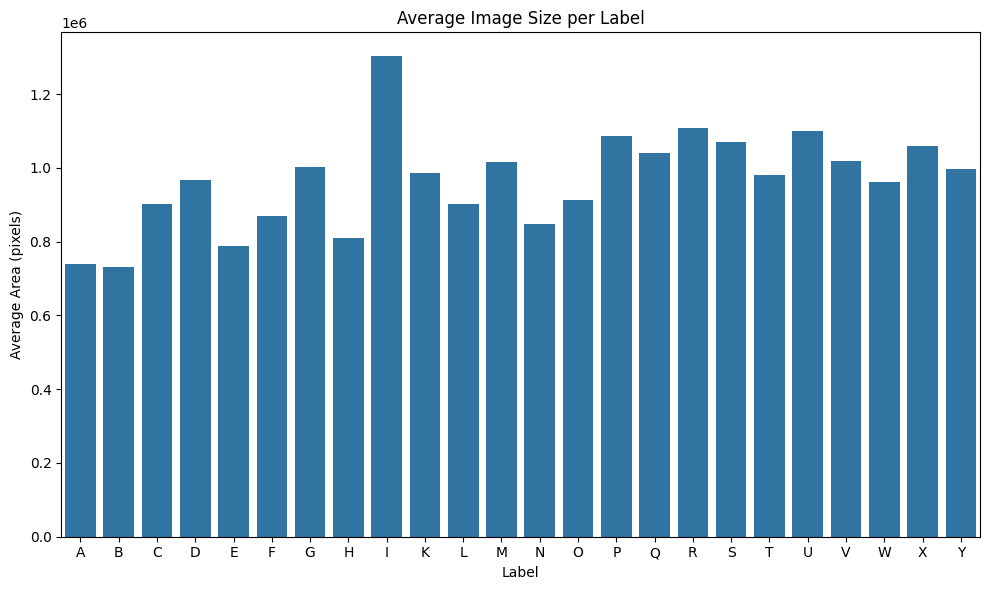

In [ ]:
# Main path to the dataset
base_path = './data/'

# Collect all image files along with their labels (subfolder names)
filepaths = []
labels = []

for label in os.listdir(base_path):
    label_path = os.path.join(base_path, label)
    if os.path.isdir(label_path):
        for fname in os.listdir(label_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                filepaths.append(os.path.join(label_path, fname))
                labels.append(label)

# Create a DataFrame
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Calculate image size (area = width × height)
def get_area(path):
    try:
        with Image.open(path) as img:
            return img.width * img.height
    except:
        return None  # skip files that cannot be opened

df['area'] = df['filepath'].apply(get_area)
df = df.dropna(subset=['area'])

# Barplot: Average image size per label
mean_area = df.groupby('label')['area'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='label', y='area', data=mean_area)
plt.title('Average Image Size per Label')
plt.xlabel('Label')
plt.ylabel('Average Area (pixels)')
plt.tight_layout()
plt.show()

Insight:

From the barplot above, we can observe that the distribution of image sizes across labels is not uniform. This indicates the need for size normalization, so that all images can be processed using a consistent input shape. This resizing step will be handled during the model definition and training phase.

Next, I will analyze the average color distribution of the images for each label.

___
### 4.2 What is the color distribution of the images for each label?

To answer this question, I will examine the average color distribution of the images for each label using the following code:

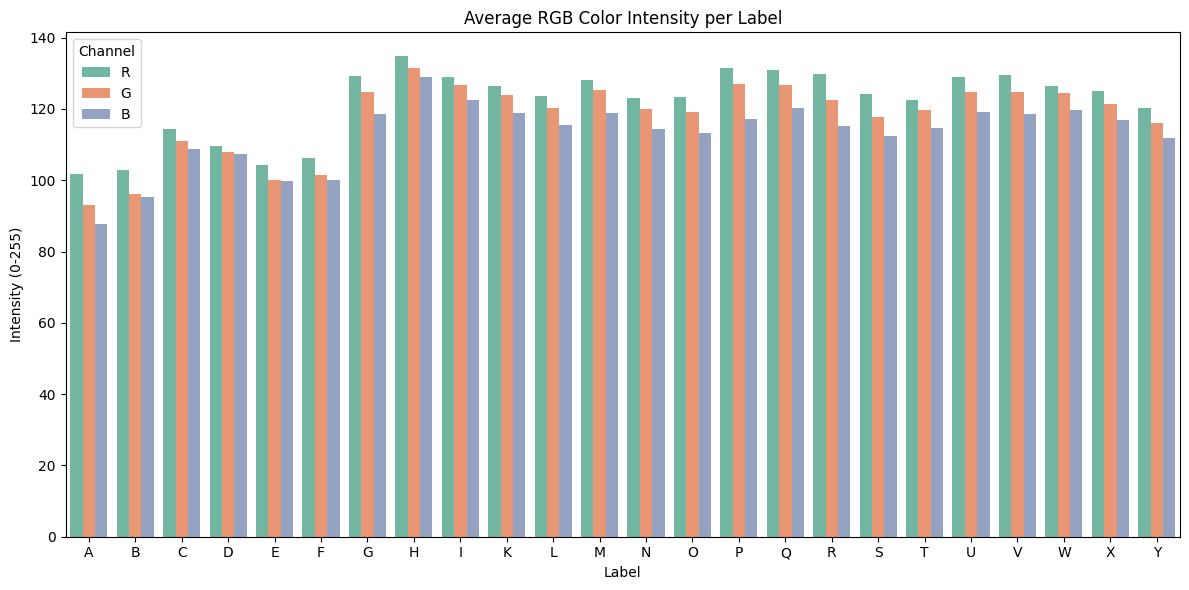

In [ ]:
# Dataset path
base_path = './data/'
filepaths, labels = [], []

# Collect image files and their associated labels (subfolder names)
for label in os.listdir(base_path):
    folder = os.path.join(base_path, label)
    if os.path.isdir(folder):
        for fname in os.listdir(folder):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                filepaths.append(os.path.join(folder, fname))
                labels.append(label)

# Create a DataFrame with file paths and labels
df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Function to extract average RGB color values
def get_avg_rgb(path):
    try:
        with Image.open(path) as img:
            img = img.convert('RGB')  # Convert to RGB format
            arr = np.array(img)
            if arr.ndim == 3:
                avg_color = arr.mean(axis=(0, 1))  # Average R, G, B values
                return pd.Series(avg_color, index=['R', 'G', 'B'])
    except:
        return pd.Series([None, None, None], index=['R', 'G', 'B'])

# Apply color extraction to each image
df[['R', 'G', 'B']] = df['filepath'].apply(get_avg_rgb)

# Remove entries where RGB extraction failed
df.dropna(subset=['R', 'G', 'B'], inplace=True)

# Calculate average RGB values per label
mean_colors = df.groupby('label')[['R', 'G', 'B']].mean().reset_index()

# Plot the average RGB color distribution by label
plt.figure(figsize=(12, 6))
mean_colors_melted = mean_colors.melt(id_vars='label',
                                      value_vars=['R', 'G', 'B'],
                                      var_name='Channel',
                                      value_name='Mean Value')

sns.barplot(x='label', y='Mean Value', hue='Channel',
            data=mean_colors_melted, palette='Set2')
plt.title('Average RGB Color Intensity per Label')
plt.ylabel('Intensity (0–255)')
plt.xlabel('Label')
plt.tight_layout()
plt.show()

Insight:

From the barplot above, we can conclude that each label has its own unique average color characteristics. However, the overall color proportions across all images are relatively consistent—red tends to dominate, followed by green, with blue being the least intense.

This occurs because human hand color patterns do not vary significantly. Skin tones generally range from light to dark shades, but they remain within natural boundaries. We don’t encounter green skin tones like animated characters in Hulk, nor blue tones like those in Avatar.

Next, I will describe the distinct visual characteristics found in the images of each label.

___
### 4.3 What are the distinct characteristics or unique features of the sign language gestures for each label?

To answer this question, I’ve described the unique visual traits of each hand gesture associated with the ASL letters:


1. Letter A

    The hand is clenched into a fist with the thumb positioned beside the index finger

2. Letter B

    All fingers (except the thumb) are fully extended and close together, while the thumb points inward toward the palm.

3. Letter C

    All fingers and the thumb are extended and spaced to form the shape of the letter “C”.

4. Letter D

    Similar to “C”, but the thumb touches the middle finger while the index finger points upward
    
5. Letter E

    Like the “A” gesture, but all four fingers (except the thumb) are bent upward at a 90° angle.

6. Letter F

    All fingers are extended, with the index finger and thumb touching at their tips.

7. Letter G

    Similar to a sideways pointing gesture, with the thumb next to the index finger

8. Letter H

    Similar to “G”, but with the middle finger added next to the index finger

9. Letter I

    Like “A”, but the pinky finger is extended upwards.

10. Letter K

    Looks like a “V” or the number “2”, but the thumb is placed between the base of the index and middle fingers

11. Letter L

    Starts with a closed fist; the thumb and index finger are extended to form the shape of an “L”.

12. Letter M

    Similar to “A”, but the thumb is tucked between the pinky and ring fingers

13. Letter N

    Similar to “M”, but the thumb is placed between the middle and ring fingers
    
14. Letter O

    Similar to “C”, but the thumb and index fingertips meet to form an “O”.

15. Letter P

    Similar to “G”, but the thumb and index finger touch, and the wrist rotates so the palm faces downward.

16. Letter Q

    Similar to “C”, but the hand is oriented downward.

17. Letter R

    Resembles the number “2”, but the index finger is placed over or under the middle finger

18. Letter S

    Like “A”, but the thumb shifts forward, near the joint of the middle finger (as in a punching motion), with the palm facing forward.

19. Letter T

    Like “N”, but the thumb is tucked between the index and middle fingers

20. Letter U

    The index and middle fingers are held tightly together, forming a closed “2”.

21. Letter V

    A classic “V” shape using the index and middle fingers.

22. Letter W

    All fingers except the thumb form the number “3”.

23. Letter X

    Looks like a “1”, but with the index finger slightly bent inward.

24. Letter Y

    The hand is clenched into a fist, with only the pinky and thumb extended.

___

After completing the EDA process, the next stage is Feature Engineering, particularly focused on data augmentation to enrich the training dataset. These techniques include:

- Horizontal flips (left-right mirror)

- Vertical flips (top-bottom)

- Rotation and shear transformations

- Zoom in/out operations

- Normalization and contrast adjustments

Important Notes:

Augmentation must be applied logically, ensuring no unnatural distortions. For example, a car image with wheels on top would be considered invalid.

Purpose of Data Augmentation:
1. Reduces model overfitting,
2. Improves generalization, dan
3. Enhances training efficiency.

Here are key components considered during model architecture design:

1. Stride (Filter shift during convolution (default = 1×1). Larger stride reduces output dimensions and computation time but may lose feature detail.)

2. Padding (Controls output dimensions. 'valid' focuses on center features, while 'same' retains edges for full-image coverage.)

3. Pooling to reduces pixel dimensions. MaxPooling preserves dominant features (ideal for recognition), while AveragePooling smooths detail.

4. Flatten / Global Average Pooling (Flatten converts 2D spatial features to 1D—useful for complex detection. GlobalAveragePooling averages feature maps—preferred for clean classification and reduced overfitting)

5. Augmentation (Random transformations (by TensorFlow) like flip, rotate, zoom. Helps build robustness to real-world noise. Not all images are augmented—selection is random.)

6. Batch Size (Defines sample size per training step. Smaller batches save GPU memory, larger batches speed up training but demand more resources. A balanced batch size improves both performance and efficiency)

In this sign language classification task, I will implement:

- Stride: default 1×1, aligned with 2×2 MaxPooling

- Padding: 'same' to preserve edge features

- Pooling: MaxPooling to retain key hand features

- Flattening: use Global Average Pooling for compact and efficient recognition

- Augmentation Techniques:

    - Horizontal flip

    - Color contrast adjustment (+10%)

    - Random zoom (±10%)

    - Pixel scaling to 1/255

___
## 5. Feature Engineering

In the feature engineering stage, I begin by configuring the dataset, which involves organizing the data by its directory or file location. The image dimensions are set to 227 × 227 pixels, as this resolution will be used in the second phase of transfer learning model improvement. This resizing ensures that all processed images have a consistent shape for model compatibility.

In [ ]:
# === Dataset Configuration ===
base_path = './split_data/'
img_height, img_width = 227, 227  # Set image size to 227×227 pixels for consistency

# Define paths to training, validation, and test directories
train_path = os.path.join(base_path, 'training')    
val_path   = os.path.join(base_path, 'validation')  
test_path  = os.path.join(base_path, 'test')        

# === Load Datasets ===
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),            # Resize images to 227×227 pixels
    label_mode='int',                              # Return integer labels (0–23)
    seed=42                                        # Set seed for reproducibility
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    image_size=(img_height, img_width),            # Resize images to 227×227 pixels
    label_mode='int',                              # Return integer labels (0–23)
    seed=42                                        # Set seed for reproducibility
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(img_height, img_width),            # Resize images to 227×227 pixels
    label_mode='int'                               # Return integer labels (0–23)
)

# === Retrieve Detected Class Names ===
class_names = raw_train_ds.class_names            # Get class names from training directory
print("Detected Classes:", class_names)           # Print list of class names

Found 5932 files belonging to 24 classes.
Found 1255 files belonging to 24 classes.
Found 1255 files belonging to 24 classes.
Kelas yang terdeteksi: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']


___
Now that the dataset has been separated based on directory structure, the next step is data augmentation. This process introduces variation to the images by applying transformations based on selected parameters.

In [ ]:
# === Data Augmentation Pipeline ===
data_augment = Sequential([                          # Create augmentation pipeline for training data
    RandomFlip("horizontal"),                        # Apply horizontal flip
    RandomZoom(0.1),                                 # Apply 10% zoom
    RandomContrast(0.1),                             # Adjust image contrast by ±10%
    Rescaling(1./255)                                # Normalize pixel values to [0, 1]
])

# Apply augmentation to training dataset
train_ds = raw_train_ds.map(lambda x, y: (data_augment(x, training=True), y))

# === Normalize Validation and Test Sets (No Augmentation) ===
normalizer = Sequential([Rescaling(1./255)])         # Only normalize pixel values

val_ds = val_ds.map(lambda x, y: (normalizer(x), y)) # Normalize validation set
test_ds = test_ds.map(lambda x, y: (normalizer(x), y)) # Normalize test set

# === Enable Cache & Prefetch for Performance Optimization ===
AUTOTUNE = tf.data.AUTOTUNE                                  # Let TensorFlow choose optimal buffer size
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)   # Efficient batch caching and preloading
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)     # Validation set optimization
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)    # Test set optimization

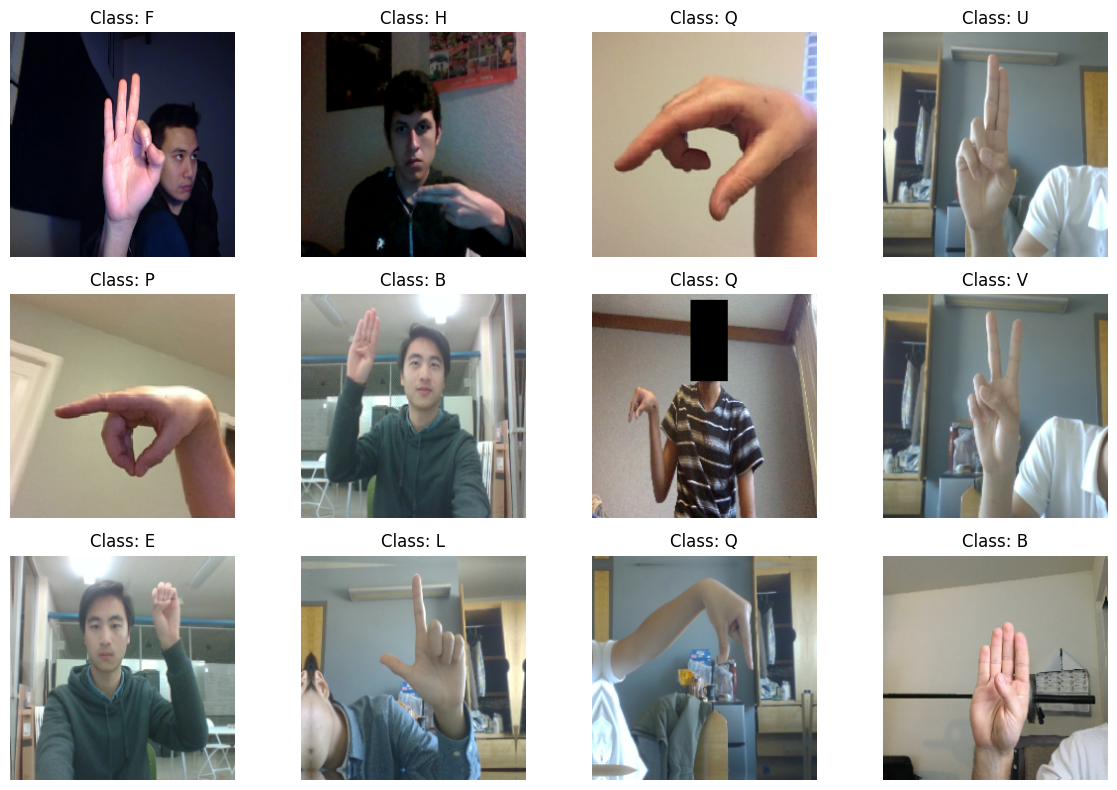

In [ ]:
# === Visualize Augmented Training Images ===
for images, labels in train_ds.take(1):            # Take one batch from augmented training dataset
    plt.figure(figsize=(12, 8))                     # Set figure size

    for i in range(12):                             # Display the first 12 images
        label_idx = labels[i].numpy()               # Convert label to integer
        label_name = class_names[label_idx]         # Get class name from index
        ax = plt.subplot(3, 4, i + 1)                # Create subplot (3 rows × 4 columns)
        ax.imshow(images[i].numpy())                # Display image
        ax.set_title(f"Class: {label_name}", fontsize=12)  # Show class name
        ax.axis("off")                              # Remove axes for clean view

    plt.tight_layout()
    plt.show()
    break

Insight:

After completing the data augmentation process, the next phase is the Artificial Neural Network (ANN) modeling session.

This session consists of two stages:

- Basic Model – The initial model is built and trained on the dataset to establish a performance baseline.

- Model Improvement – Enhancements are introduced to boost model performance, aiming for higher accuracy in image prediction.


___
## 6. ANN Training (Sequential API)

### 6.1 Model Definition

In this stage, CNN-based modeling is applied throughout the program.

Artificial Neural Network (ANN) is a computational model inspired by how the human brain works. It consists of interconnected layers of artificial neurons that learn patterns from training data.

Think of ANN as a digital version of the human brain: each layer contains "neurons" that take input values, perform simple operations, and pass the results to the next neuron.
ANN is best suited for structured and sequential data, such as numbers, text, or tabular datasets.


Convolutional Neural Network (CNN) is a specialized form of ANN designed for processing image-like data.
It excels at recognizing spatial patterns and visual features through convolution operations.

CNN uses special layers called convolutional layers that can “see” small details in images—edges, corners, textures, etc.

CNN is highly efficient and accurate for tasks like:
- Image classification
- Object detection
- Hand gesture recognition

- Example applications: facial recognition, alphabet classification, photo filter

The model used is Sequential, meaning layers are arranged linearly from input to output.
Each layer processes the output of the previous one, making the flow intuitive and straightforward to implement.

The most commonly used activation function in convolutional and dense layers is ReLU (Rectified Linear Unit), known for its simplicity and effectiveness.

Advantages of ReLU:

- Non-linearity: Enables the network to learn complex relationships between features
- Fast computation: Simply returns the maximum of zero and the input
- Avoids vanishing gradients: Keeps gradients active for positive values
- Sparsity: Negative values become zero, leading to more efficient representations and reduced overfitting

When to Use ReLU:

- Almost in all layers except the output
- For multi-class classification, the output layer typically uses softmax
- For regression tasks, the output layer usually has no activation (linear output)

Why Use Softmax in This Project?

- Multi-class Classification Objective

    This project focuses on classifying ASL hand gestures into alphabet letters (A–Z). Since only one label is correct per image, softmax is ideal.

- Probability Output

    Softmax converts raw output scores into a probability distribution, where all class scores sum to 1. This makes it easy to interpret which label is most likely.

- Training Stability

    Softmax provides clear signals to the loss function (usually categorical_crossentropy), helping it understand how incorrect a prediction is compared to the true label.
___

In [ ]:
model1 = Sequential([                               # Sequential model: layers are stacked linearly

    Conv2D(16, (3, 3),                               # First convolutional layer: 16 filters of size 3x3
           activation='relu',                       # Activation function: ReLU
           padding='same',                          # 'Same' padding to preserve spatial dimensions
           input_shape=(img_height, img_width, 3)), # Input shape: 227×227 pixels, 3 color channels (RGB)

    MaxPooling2D(2, 2),                             # First pooling layer: reduces dimensionality, extracts dominant features

    Conv2D(32, (3, 3), activation='relu', padding='same'),  # Second convolutional layer with 32 filters
    MaxPooling2D(2, 2),                             # Second pooling layer: further compresses features

    GlobalAveragePooling2D(),                       # Global average pooling: computes spatial average across feature maps
                                                    # More lightweight than flatten and ideal for image classification

    Dropout(0.3),                                   # Dropout (30%): regularization to reduce overfitting
    Dense(64, activation='relu'),                   # Dense layer with 64 units for deeper feature processing
    Dropout(0.2),                                   # Dropout (20%): additional regularization

    Dense(24, activation='softmax')                 # Output layer: 24 neurons for class prediction (A–X),
                                                    # Softmax activation to produce probability scores
])

___
Once the model architecture is defined, the next step is to prepare it for training through the compilation process.
The model is compiled using the Adam optimizer (Adaptive Moment Estimation), which is known for its fast convergence and stability across diverse datasets. 

A learning rate of 0.0005 is applied to control how quickly the model adapts during training.

For the loss function, Sparse Categorical Crossentropy is chosen since the labels have been encoded as integers. The model's performance will be evaluated using the accuracy metric, which tracks the proportion of correct predictions.

In [ ]:
model1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),  # Adam optimizer with a low learning rate for training stability
    loss='sparse_categorical_crossentropy',                    # Suitable loss function for integer-encoded labels
    metrics=['accuracy']                                       # Evaluation metric: classification accuracy
)

model1.summary()  # Display model summary including layer structure and total parameters

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 227, 227, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 113, 113, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 113, 113, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 global_average_pooling2d (  (None, 32)                0         
 GlobalAveragePooling2D)                                         
                                                      

Next, the early stopping mechanism is configured.
Early stopping is used to terminate training when the model's performance no longer improves after a certain number of iterations or epochs. This helps prevent overfitting and ensures that computational resources are used efficiently.

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',                 # Monitor the validation loss to decide when to stop training
    patience=5,                         # Stop training if no improvement after 5 consecutive epochs
    restore_best_weights=True,         # Restore model weights from the epoch with the lowest val_loss
    verbose=1                          # Show a message when training stops early
)

Next, the model enters the training phase, where it begins learning from the data provided.

___
### 6.2 Model Training

In [ ]:
%%time
history1 = model1.fit(
    train_ds,                          # Augmented and normalized training dataset
    validation_data=val_ds,            # Validation dataset to monitor performance after each epoch
    epochs=20,                         # Maximum number of training epochs
    callbacks=[early_stop],            # Enable EarlyStopping to automatically halt training if no improvement
    verbose=1                          # Display training progress logs in the console
)

Epoch 1/20
186/186 [==============================] - 23s 115ms/step - loss: 3.1730 - accuracy: 0.0561 - val_loss: 3.1680 - val_accuracy: 0.0637
Epoch 2/20
186/186 [==============================] - 33s 172ms/step - loss: 3.1532 - accuracy: 0.0671 - val_loss: 3.2273 - val_accuracy: 0.0637
Epoch 3/20
186/186 [==============================] - 35s 180ms/step - loss: 3.1081 - accuracy: 0.0679 - val_loss: 3.7842 - val_accuracy: 0.0637
Epoch 4/20
186/186 [==============================] - 26s 136ms/step - loss: 3.0831 - accuracy: 0.0791 - val_loss: 3.8766 - val_accuracy: 0.0645
Epoch 5/20
186/186 [==============================] - 26s 138ms/step - loss: 3.0718 - accuracy: 0.0757 - val_loss: 3.6615 - val_accuracy: 0.0645
Epoch 6/20
186/186 [==============================] - 26s 136ms/step - loss: 3.0522 - accuracy: 0.0814 - val_loss: 3.5356 - val_accuracy: 0.0645
Epoch 6: early stopping
Wall time: 2min 56s


Insight:

From the training results above, it appears that the model has not yet successfully captured the underlying characteristics of the processed data.
To improve its performance, model enhancement is needed—this may involve increasing the number of hidden layers or adjusting the data augmentation strategy.

Before moving on to the improvement phase, I’d like to visualize the accuracy and loss curves from the baseline model.
___

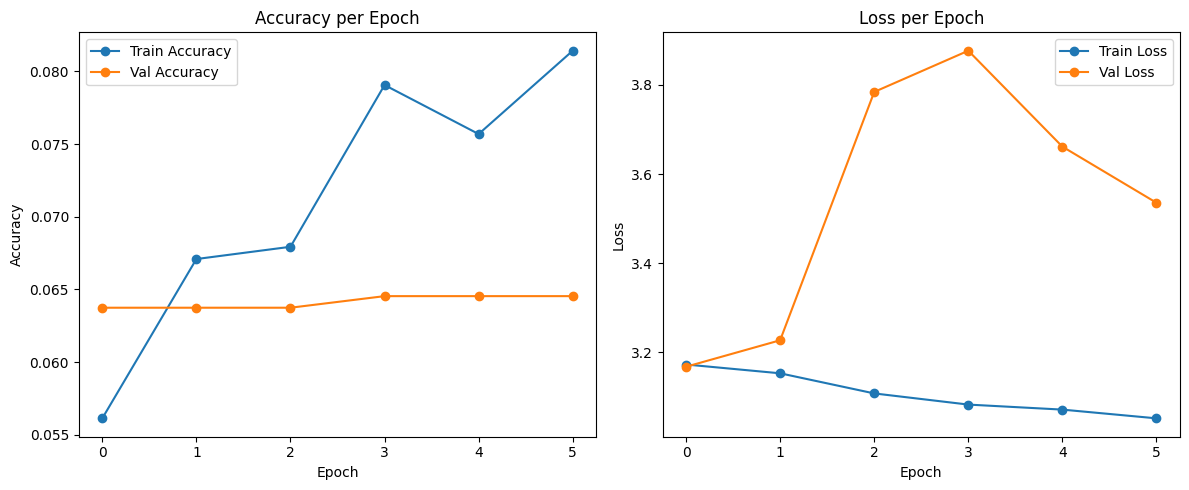

In [ ]:
plt.figure(figsize=(12, 5))  # Set the overall figure size

# === Accuracy Visualization ===
plt.subplot(1, 2, 1)  # First subplot: Accuracy curve
plt.plot(history1.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# === Loss Visualization ===
plt.subplot(1, 2, 2)  # Second subplot: Loss curve
plt.plot(history1.history['loss'], label='Train Loss', marker='o')
plt.plot(history1.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Insight:

From the visualization, it’s clear that the model’s performance is poor. The validation accuracy hovers between 0.063 and 0.065, while the validation loss fluctuates drastically, indicating unstable learning and weak generalization.
___

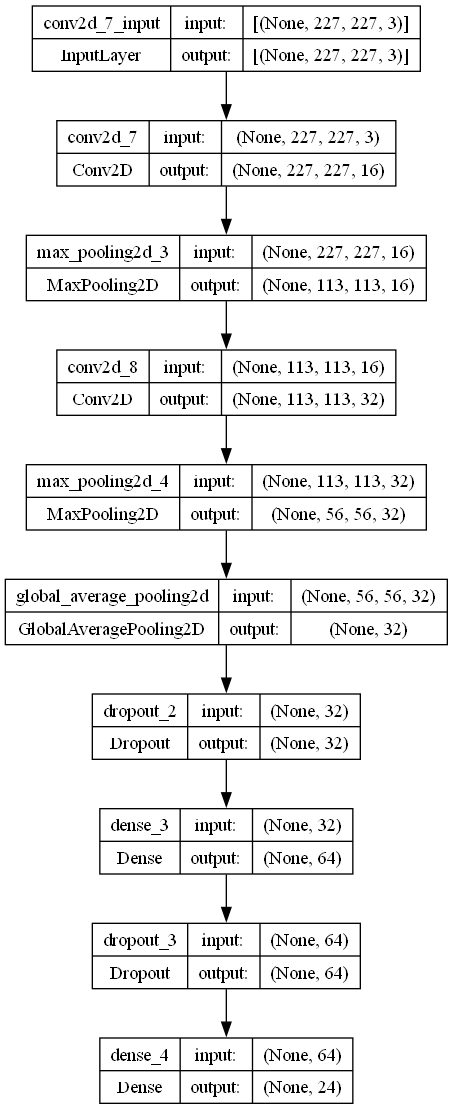

In [35]:
# Plot layers
tf.keras.utils.plot_model(model1, show_shapes=True)

Insight:

Layer                  | Output Shape     | Deskripsi
----------------------|------------------|-----------------------------------------------
Input (227x227x3)     | (227, 227, 3)    | RGB image resized to 227×227
Conv2D (16 filters)   | (227, 227, 16)   | Initial feature extraction with 3×3 filters
MaxPooling2D          | (113, 113, 16)   | Spatial downsampling using 2×2 pooling
Conv2D (32 filters)   | (113, 113, 32)   | Deeper feature extraction with 3×3 filters
MaxPooling2D          | (56, 56, 32)     | Further spatial reduction
GlobalAvgPooling2D    | (32,)            | Channel-wise feature compression
Dropout (0.3)         | (32,)            | Regularization by dropping 30% of neurons
Dense (64 units)      | (64,)            | Fully connected layer for refined feature learning
Dropout (0.2)         | (64,)            | Additional regularization, 20% dropout
Dense (24 units)      | (24,)            | Output layer with softmax for 24-class prediction

___
### 6.3 Model Evaluation

From the results of the baseline ANN model, it’s clear that the model has not effectively learned the visual characteristics of the sign language images. The performance remains poor, with accuracy below 10%, which indicates that the model is not capturing meaningful patterns.

Strengths of the First Model:

1. Simplicity — The architecture is straightforward and quick to build.

2. Lightweight — The model requires minimal computational power, making it efficient for testing small datasets or rapid prototyping.

Weaknesses of the First Model:

1. Low Accuracy — Due to the model's simplicity, it fails to learn and generalize from the data effectively.

2. Unsuitable for Deployment — The model is not reliable enough for inference or deployment in user-facing applications.

___
## 7. ANN Improvement (Sequential API)

There are many ways to enhance an Artificial Neural Network (ANN) model, including:

- Adjusting data augmentation parameters

- Increasing the size of the training dataset

- Adding more hidden layers to the CNN architecture

- Changing the batch size

- And many other techniques to optimize learning and generalization

In this project, I conducted multiple rounds of model refinement—such as increasing the number of layers and adjusting the batch size.

However, due to the large volume of data being processed, each training session took approximately 1 hour per model, which required significant computational resources.

To maintain efficiency and focus on quality, I selected one best-performing model for the final stage of model improvement and evaluation.


___
### 7.1 Model Definition

The best-performing model selected for this project leverages transfer learning, using the AlexNet architecture—a highly effective CNN design for image classification.

AlexNet was developed by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton, and it gained international recognition by winning the ImageNet competition in 2012, achieving the highest accuracy among competing models at the time. Its architecture was groundbreaking in demonstrating deep convolutional networks' ability to extract complex visual patterns.

The original AlexNet architecture is structured as follows:

Input: 227 × 227 × 3 (RGB image)

→ Conv2D (96 filters, 11×11 kernel, stride 4)

→ MaxPooling

→ Conv2D (256 filters, 5×5 kernel)

→ MaxPooling

→ Conv2D (384 filters, 3×3 kernel)

→ Conv2D (384 filters, 3×3 kernel)

→ Conv2D (256 filters, 3×3 kernel)

→ MaxPooling

→ Flatten

→ Dense (4096 units) + Dropout

→ Dense (4096 units) + Dropout

→ Dense (1000 units) + Softmax

A study conducted by Singh et al., focusing on sign language image recognition using AlexNet, reported outstanding performance with an accuracy of 99.6%.
[link](https://link.springer.com/chapter/10.1007/978-981-19-7524-0_46). 

Key Findings from the Research:

- High Performance in recognizing hand gestures from RGB-format images

- Efficient Training, requiring relatively low computational resources

Given these advantages, I’ll adopt AlexNet as the foundation for my model improvement phase.

___
### 7.2 Model Training

In this model improvement phase, I will:

- Rebuild the dataset pipeline by reloading data from its directory structure

- Apply targeted data augmentation to enrich training diversity

- Implement the AlexNet architecture for CNN modeling

Initial Adjustments:

Before launching into model building, I will:

- Change the image dimensions to match AlexNet’s required input size

- Adjust the batch size to optimize training efficiency and memory usage

These steps ensure that the dataset is properly configured for AlexNet’s architecture and training process.


In [14]:
img_height, img_width = 227, 227
batch_size = 32
num_classes = 24
input_shape = (img_height, img_width, 3)

In [ ]:
reg = regularizers.l2(0.001)  # Apply L2 regularization to reduce overfitting by penalizing large weights

model3 = Sequential([
    # Initial large convolution layer typical of AlexNet—captures global visual features
    Conv2D(96, (11, 11), strides=4, activation='relu', input_shape=input_shape, kernel_regularizer=reg),
    BatchNormalization(),               # Stabilizes activation distributions and speeds up training
    MaxPooling2D((3, 3), strides=2),    # Spatial downsampling and noise reduction

    # Deeper convolution with smaller kernel—captures detailed features
    Conv2D(256, (5, 5), padding='same', activation='relu', kernel_regularizer=reg),
    BatchNormalization(),               # Reduces covariate shift across mini-batches
    MaxPooling2D((3, 3), strides=2),    # Second pooling layer for further dimensionality reduction

    # Deeper feature extraction layers
    Conv2D(384, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
    Conv2D(384, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
    Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
    Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
    Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=reg),
    MaxPooling2D((3, 3), strides=2),    # Final pooling layer for spatial generalization

    Flatten(),  # Convert 3D feature maps into a 1D feature vector

    # Fully connected layers for high-level feature processing
    Dense(1024, activation='relu', kernel_regularizer=reg),
    Dropout(0.5),  # Dropout (50%) to prevent overfitting

    Dense(1024, activation='relu', kernel_regularizer=reg),
    Dropout(0.5),  # Additional dropout for regularization

    # Output layer for multi-class classification (24 classes)
    Dense(num_classes, activation='softmax', kernel_regularizer=reg)
])

# Compile the model with Adam optimizer and sparse categorical loss for integer-labeled classes
model3.compile(optimizer=Adam(learning_rate=0.001),
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model3.summary()  # Display model architecture and parameter count


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (Batch  (None, 55, 55, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                     

The model is now fully configured and ready to begin the training process.
___

In [ ]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss',       # Monitor validation loss for stagnation
    factor=0.5,               # Reduce learning rate by a factor of 0.5 if no improvement
    patience=3,               # Trigger reduction after 3 stagnant epochs
    verbose=1                 # Display log when learning rate is updated
)

# === 6. Training Phase (Max 20 Epochs) ===
history3 = model3.fit(
    train_ds,                          # Augmented and normalized training dataset
    validation_data=val_ds,            # Validation set to monitor model performance each epoch
    epochs=20,                         # Max 20 epochs (can stop earlier via EarlyStopping)
    callbacks=[early_stop, lr_reduce], # Use EarlyStopping and LR scheduler for efficient, stable training
    verbose=1                          # Show detailed training metrics and progress in console
)

Epoch 1/20


186/186 [==============================] - 183s 976ms/step - loss: 5.3084 - accuracy: 0.1043 - val_loss: 4.3866 - val_accuracy: 0.1012 - lr: 0.0010
Epoch 2/20
186/186 [==============================] - 180s 971ms/step - loss: 3.6755 - accuracy: 0.2254 - val_loss: 3.7995 - val_accuracy: 0.1657 - lr: 0.0010
Epoch 3/20
186/186 [==============================] - 171s 921ms/step - loss: 3.0841 - accuracy: 0.3356 - val_loss: 2.8603 - val_accuracy: 0.3976 - lr: 0.0010
Epoch 4/20
186/186 [==============================] - 173s 929ms/step - loss: 2.7368 - accuracy: 0.4474 - val_loss: 2.5221 - val_accuracy: 0.5315 - lr: 0.0010
Epoch 5/20
186/186 [==============================] - 158s 847ms/step - loss: 2.5527 - accuracy: 0.5170 - val_loss: 2.9793 - val_accuracy: 0.4056 - lr: 0.0010
Epoch 6/20
186/186 [==============================] - 179s 960ms/step - loss: 2.4177 - accuracy: 0.5664 - val_loss: 2.9625 - val_accuracy: 0.4143 - lr: 0.0010
Epoch 7/20
186/186 [========================

Insight:

The training results clearly show a dramatic improvement in model performance compared to the baseline.
The second model, built using transfer learning with AlexNet, achieved an accuracy of 88.9% on the training data and 82% on the validation data.

This means the model correctly predicts the sign language images with 82% accuracy on unseen data, demonstrating strong generalization and feature learning.
___

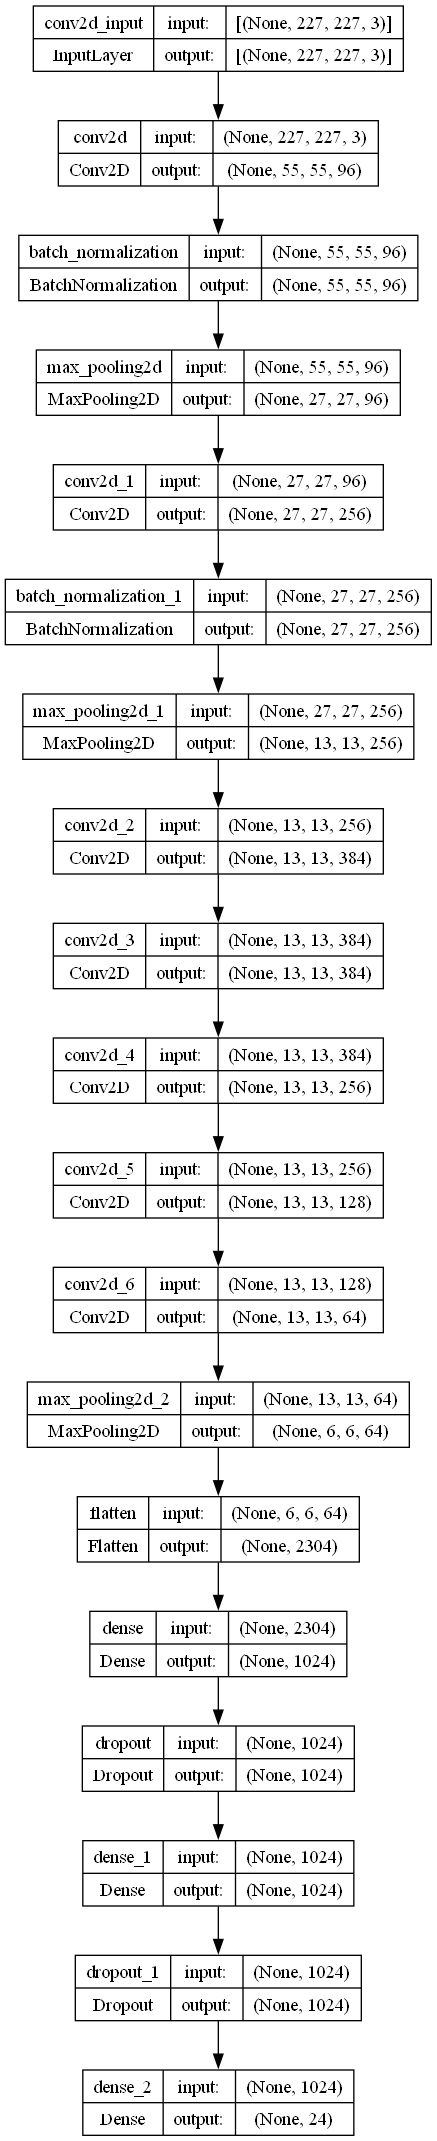

In [18]:
# Plot layers
tf.keras.utils.plot_model(model3, show_shapes=True)

Insight:

Training Workflow of the Second Model (Transfer Learning – AlexNet)

Layer Name         | Output Shape        | Description
------------------ | ------------------- | -----------------------------------------------------------
InputLayer         | (None, 227, 227, 3) | RGB image input resized to 227×227
Conv2D (96 filters)| (None, 55, 55, 96)  | Large convolution layer with stride 4 for global feature extraction
BatchNormalization | (None, 55, 55, 96)  | Stabilizes activation distribution and accelerates convergence
MaxPooling2D       | (None, 27, 27, 96)  | Spatial compression and dimensionality reduction
Conv2D (256 filters)| (None, 27, 27, 256)| Intermediate convolution layer to capture local patterns
BatchNormalization | (None, 27, 27, 256) | Batch-wise normalization for training stability
MaxPooling2D       | (None, 13, 13, 256) | Further spatial downsampling
Conv2D (384 filters)| (None, 13, 13, 384)| Complex feature extraction
Conv2D (384 filters)| (None, 13, 13, 384)| Stacked convolution for deeper representation
Conv2D (256 filters)| (None, 13, 13, 256)| Reduces feature depth to refine salient information
Conv2D (256 filters)| (None, 13, 13, 256)| Additional convolution to reinforce spatial encoding
Conv2D (64 filters) | (None, 13, 13, 64) | Fine-tuning visual representation with small filters
MaxPooling2D       | (None, 6, 6, 64)    | Final pooling layer before flattening
Flatten            | (None, 2304)        | Converts feature maps into a 1D vector
Dense (1024 units) | (None, 1024)        | High-capacity fully connected layer for classification
Dropout            | (None, 1024)        | Regularization by deactivating 50% of neurons
Dense (1024 units) | (None, 1024)        | Second dense layer for feature fusion
Dropout            | (None, 1024)        | Further dropout for model generalization
Dense (24 units)   | (None, 24)          | Softmax output layer for 24 alphabet gesture classes

___
### 7.3 Model Evaluation

To evaluate the model's performance, I will examine its classification testing results

In [ ]:
# Path to training dataset directory
train_dir = './split_data/training/'

# Retrieve class names from folder names
class_names = sorted([
    name for name in os.listdir(train_dir)
    if os.path.isdir(os.path.join(train_dir, name))
])
print("Class Names:", class_names)

# Predict class probabilities for the test dataset
y_pred_prob_aug = model3.predict(test_ds)

# Convert probabilities to predicted class indices (argmax)
y_pred_class_aug = np.argmax(y_pred_prob_aug, axis=1)

# Extract true labels from the test dataset (unbatched to get individual samples)
y_true = []
for _, label in test_ds.unbatch():
    y_true.append(label.numpy())
y_true = np.array(y_true)

# Validate shape of label arrays
print("True labels shape:", y_true.shape)
print("Predicted labels shape:", y_pred_class_aug.shape)

# Display classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred_class_aug, target_names=class_names))

Class Names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
40/40 [==============================] - 7s 161ms/step
True labels shape: (1255,)
Predicted labels shape: (1255,)
              precision    recall  f1-score   support

           A       0.89      0.91      0.90        80
           B       0.88      0.80      0.84        81
           C       0.82      0.93      0.87        58
           D       0.83      0.71      0.77        56
           E       0.67      0.85      0.75        74
           F       0.95      0.90      0.93        63
           G       0.91      0.80      0.85        51
           H       0.86      0.89      0.87        54
           I       0.88      0.85      0.87        54
           K       0.79      0.87      0.83        47
           L       0.85      0.78      0.82        51
           M       0.73      0.85      0.79        41
           N       0.97      0.79      0.87      

Insight:

As confirmed by previous evaluations, the model achieves an average label prediction accuracy between 75–85%, demonstrating solid performance in sign language image classification.

This improvement is largely due to the significant architectural differences from the baseline model. It's clear that variations in layer depth, parameter configuration, and data augmentation strategies can profoundly impact the effectiveness of an Artificial Neural Network (ANN).

___
## 8. Conclusion & Recommendation

### 8.1 Conclusion

Designing an ANN architecture for computer vision tasks in deep learning can be challenging for many practitioners, myself included. This complexity arises from the fact that data scientists must conduct extensive **trial-and-error experimentation** across various machine learning and deep learning models.

In my project, the improved model achieved a reasonably strong performance, with **89% accuracy on the training data** and **82% on the validation set**. However, despite these numbers, the model showed signs of **overfitting**, learning specific patterns and shapes too well during fitting—resulting in poor performance during model inference.

This degradation during inference can be attributed to several factors:

1. **Insufficient and imbalanced dataset**
2. **Suboptimal model architecture**
3. **Ineffective data augmentation strategy**
4. **Low diversity in the processed image data**

Thus, although the model demonstrated high performance during training, its inability to generalize well during prediction means it cannot be considered suitable for real-world deployment. Due to time constraints, further refinement to enhance predictive capability could not be completed.

### 8.2 Recommendation

For future research and improvement, the following suggestions are proposed:

- **Increase the dataset volume** and introduce **greater variation** in American Sign Language (ASL) image samples.
- Consider utilizing **deeper neural architectures** with multiple hidden layers to enhance feature extraction and generalization capability.

That said, deploying deeper models demands substantial computational resources and comes with added risks such as **vanishing gradients** and **overfitting**. These issues can be mitigated using techniques such as **batch normalization**, **dropout**, and **L2 regularization**.

Reference: [How to decide the number of hidden layers](https://mljourney.com/how-to-decide-the-number-of-hidden-layers-in-a-neural-network)

Notably, very deep models like **ResNet**, **VGG**, or **Transformers** are widely used for complex visual and NLP tasks. For instance, the VGG architecture introduced by **Simonyan et al. (2014)** featured **over 16 hidden layers**, exemplifying the power and depth of modern CNNs.

Reference: [Minimum number of layers in a deep neural network](https://stats.stackexchange.com/questions/229619/minimum-number-of-layers-in-a-deep-neural-network)

---
